Created on Fri Sep  1 18:51:52 2023
Updated in Oct 2024
@author: Milan Salek

This script creates a plot that shows the main components of the 
radiation imbalance as measured by CERES project

The CERES data are from the web site:
https://ceres.larc.nasa.gov/data/#ebaftoa-level-3

Order EBAF-TOA, Level 3b data 
(Observed TOA all-sky and clear-sky fluxes; CERES-MODIS cloud properties. 
Clear-sky for cloud free areas of 1°x1° region.)

Some sources of algorithms for beginners in xarray and NetCDF:
https://earth-env-data-science.github.io/assignments/basic_xarray.html
https://fabienmaussion.info/climate_system/week_02/01_Lesson_NetCDF_Data.html

The Gistemp data are from https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Monthly_Mean_Global_Surface_Temperature/graph.txt
You have to adjust/edit the dataset to the correct time range according to the CERES dataset
starting by 2000.21 (March 2000) and ending by the same month as the CERES data
See also # Defining the start and end date below!

The global average is computed by the same algorithm as the global average of
weighted temperature:
https://docs.xarray.dev/en/stable/examples/area_weighted_temperature.html

All the resulting values are rolling/moving average!


In [21]:

import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['figure.figsize'] = (12, 6)
import netCDF4 as nc
from scipy import signal
from datetime import datetime,timedelta

avg_temp_Earth = 14.5  # rather arbitrary, not important
end_year=2026  # for the max limit of the final graphs
# kernel (number of months for moving averages)
kernel=12


In [22]:
fpath_ceres = "./CERES_EBAF-TOA_Ed4.2.1_Subset_200003-202509.nc"   # NetCDF file with the radiation fluxes, needs to be downloaded manually
ds = xr.open_dataset(fpath_ceres, engine='netcdf4')

Setting datetime limits of the data series by strptime warkaround. As the datetime format is too fine, we have to limit the datetime to seconds. %Y-%m-%dT%H:%M:%S.%f expects exactly 6 digits for microseconds, but the numpy.datetime64 offers 9 digits (try print (ds.time.values[0], type(ds.time.values[0]))). Therefore The .000000000 in the string needs to be trimmed to .000000 for strptime to work

In [23]:
time_values = ds.time.values
start_time_string = np.datetime_as_string(time_values[0])
end_time_string = np.datetime_as_string(time_values[-1])
start_time = datetime.strptime(start_time_string[:26],"%Y-%m-%dT%H:%M:%S.%f")
end_time = datetime.strptime(end_time_string[:26],"%Y-%m-%dT%H:%M:%S.%f")

In [24]:
print(start_time_string, start_time, end_time) 

2000-03-15T00:00:00.000000000 2000-03-15 00:00:00 2025-09-15 00:00:00


As the gistemp values are in decimal year value (..., 2025.04,2025.13,2025.21,...), we have to convert it into this format:

In [25]:
def datetime64_to_decimal_year(dt):
    # Convert numpy.datetime64 to datetime.datetime
    # dt = np.datetime_as_string(dt64, unit='s')  # Convert to string
    # dt = datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")  # Parse string

    year_start = datetime(dt.year, 1, 1)
    year_end = datetime(dt.year + 1, 1, 1)
    year_length = (year_end - year_start).total_seconds()
    seconds_into_year = (dt - year_start).total_seconds()
    
    decimal_year = dt.year + seconds_into_year / year_length
    return decimal_year


start_year_decimal = datetime64_to_decimal_year(start_time)
end_year_decimal = datetime64_to_decimal_year(end_time)

In [26]:
print (start_year_decimal, end_year_decimal)

2000.2021857923498 2025.704109589041


In [27]:
# Reading the time series downloaded from GISTEMP NASA:
# https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Monthly_Mean_Global_Surface_Temperature/graph.csv
# The file gistemp_2024-04_reduced.csv must contain the same time span as
# the CERES_EBAF*.nc file
# gistemp_monthly_temperatures = []
# gistemp_year_decimal = []

import requests

def decimalYear2datetime(decimalYear):
    year = int(decimalYear)
    rem = decimalYear - year
    base = datetime(year, 1, 1)
    date_time = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    year_aux, month_aux = date_time.year, date_time.month
    return (datetime(year=year_aux,month=month_aux, day=15))

url = 'https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Monthly_Mean_Global_Surface_Temperature/graph.csv'
r = requests.get(url)

In [28]:
# Reading the time series downloaded from GISTEMP NASA:
# https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Monthly_Mean_Global_Surface_Temperature/graph.txt

def decimalYear2datetime(decimalYear):
    year = int(decimalYear)
    rem = decimalYear - year
    base = datetime(year, 1, 1)
    date_time = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    year_aux, month_aux = date_time.year, date_time.month
    return (datetime(year=year_aux,month=month_aux, day=15))

df_gistemp_monthly_temperatures = pd.read_csv('graph.csv', skiprows=1, header=0)
df_gistemp_monthly_temperatures.drop(["Station", "Land_Only", "Open_Ocean"], axis="columns", inplace=True)
df_gistemp_monthly_temperatures.rename(columns = {"Year+Month":"time", "Land+Ocean":"t"}, inplace=True)
df_gistemp_monthly_temperatures.head(5)
df_gistemp_monthly_temperatures = df_gistemp_monthly_temperatures[df_gistemp_monthly_temperatures.time >= (start_year_decimal - 0.05)]
df_gistemp_monthly_temperatures = df_gistemp_monthly_temperatures[df_gistemp_monthly_temperatures.time <= (end_year_decimal + 0.05)]
print (start_year_decimal, end_year_decimal)
start_date_gistemp = decimalYear2datetime(start_year_decimal)
end_date_gistemp = decimalYear2datetime(end_year_decimal)
print (start_date_gistemp, end_date_gistemp)


2000.2021857923498 2025.704109589041
2000-03-15 00:00:00 2025-09-15 00:00:00


In [29]:
df_gistemp_monthly_temperatures.tail(5)

,time,t
1744,2025.38,1.07
1745,2025.46,1.05
1746,2025.54,1.02
1747,2025.63,1.15
1748,2025.71,1.24


In [30]:
# added 20 days as we need to end with the first month with no data
time = pd.date_range(start=start_date_gistemp, end=end_date_gistemp + timedelta(days=20), freq='MS')
# Create an xarray DataArray
gistemp_array = xr.DataArray(
    df_gistemp_monthly_temperatures["t"],
    coords=[time],
    dims=["time"],
    name="monthly_time_series_data"
)


In [31]:
# Smoothing of th Gistemp data by kernel-month moving average
gistemp_months_smoothed = \
    gistemp_array.rolling(time = kernel, 
            center = True).mean()

gistemp_months_smoothed

<xarray.DataArray 'monthly_time_series_data' (time: 307)> Size: 2kB
array([       nan,        nan,        nan,        nan,        nan,
              nan, 0.3975    , 0.3975    , 0.3925    , 0.41083333,
       0.42083333, 0.4375    , 0.44333333, 0.45416667, 0.47416667,
       0.50916667, 0.53166667, 0.55833333, 0.5875    , 0.615     ,
       0.62166667, 0.6275    , 0.62833333, 0.63      , 0.63333333,
       0.64416667, 0.6475    , 0.63583333, 0.62666667, 0.62416667,
       0.6075    , 0.58416667, 0.58166667, 0.57833333, 0.57333333,
       0.57083333, 0.58      , 0.57833333, 0.59333333, 0.58916667,
       0.61416667, 0.60083333, 0.6125    , 0.615     , 0.62      ,
       0.60083333, 0.59833333, 0.57166667, 0.55583333, 0.54583333,
       0.53666667, 0.5525    , 0.5325    , 0.54583333, 0.53583333,
       0.545     , 0.55      , 0.57083333, 0.5875    , 0.61666667,
       0.62916667, 0.64666667, 0.65916667, 0.66083333, 0.675     ,
       0.66      , 0.67083333, 0.66166667, 0.64416667, 0.6325    ,
       0.63416667, 0.62833333, 0.63666667, 0.63166667, 0.62666667,
       0.62583333, 0.63583333, 0.67333333, 0.67083333, 0.6775    ,
       0.7025    , 0.71916667, 0.715     , 0.71916667, 0.71083333,
       0.70666667, 0.69666667, 0.685     , 0.66      , 0.6       ,
       0.57333333, 0.57583333, 0.5575    , 0.5425    , 0.5325    ,
       0.53333333, 0.52166667, 0.52166667, 0.52916667, 0.5375    ,
...
       0.875     , 0.85166667, 0.84666667, 0.83833333, 0.8425    ,
       0.84333333, 0.83583333, 0.84083333, 0.8525    , 0.84916667,
       0.84833333, 0.8575    , 0.86583333, 0.89      , 0.9       ,
       0.90416667, 0.91583333, 0.92416667, 0.93833333, 0.94916667,
       0.9475    , 0.96083333, 0.97666667, 0.99666667, 1.02083333,
       1.02166667, 1.03166667, 1.0425    , 1.04333333, 1.04      ,
       1.0325    , 1.035     , 1.02416667, 1.03166667, 1.005     ,
       0.975     , 0.925     , 0.90083333, 0.87083333, 0.85416667,
       0.84833333, 0.85083333, 0.84666667, 0.84333333, 0.8525    ,
       0.83916667, 0.84583333, 0.85416667, 0.875     , 0.8875    ,
       0.89333333, 0.8975    , 0.90416667, 0.90583333, 0.9175    ,
       0.915     , 0.91416667, 0.89833333, 0.8925    , 0.88916667,
       0.89583333, 0.91166667, 0.925     , 0.93333333, 0.94666667,
       0.9675    , 0.9875    , 1.03666667, 1.0675    , 1.125     ,
       1.1725    , 1.20416667, 1.24333333, 1.25666667, 1.28333333,
       1.3       , 1.31      , 1.31083333, 1.31916667, 1.29916667,
       1.2975    , 1.28666667, 1.27833333, 1.28833333, 1.2725    ,
       1.27      , 1.26333333, 1.2575    , 1.245     , 1.23      ,
       1.21833333, 1.21833333,        nan,        nan,        nan,
              nan,        nan])
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-04-01 2000-05-01 ... 2025-10-01

In [32]:
# CERES data preparation:
sw = ds.toa_sw_all_mon  # Short-wave outgoing radiation
solar_incmg = ds.solar_mon   # Solar incoming radiation
lw = ds.toa_lw_all_mon # Long-wave outgoing radiation
toa_net = ds.toa_net_all_mon

# Computation of weights that are proportional to cos(lat)
def cosine_function(x):
    return np.cos(np.radians(x))

result = xr.apply_ufunc(cosine_function, ds['lat'], keep_attrs=True)
ds['cosine_lat'] = result

# Computing the weighted average
weights = np.cos(np.deg2rad(ds.lat))
sw_weighted = sw.weighted(weights)
lw_weighted = lw.weighted(weights)
toa_net_weighted = toa_net.weighted(weights)
solar_incmg_weighted = solar_incmg.weighted(weights)

sw_weighted_mean = sw_weighted.mean(("lon", "lat")) # Computing of the areal (global) mean (short-wave outhoing) 
lw_weighted_mean = lw_weighted.mean(("lon", "lat")) # Computing of the areal (global) mean (long-wave outgoing) 
toa_net_weighted_mean = toa_net_weighted.mean(("lon", "lat")) # Computing of the areal (global) mean (radiation balance, difference) 
solar_incmg_weighted_mean = solar_incmg_weighted.mean(("lon", "lat")) # Computing of the areal (global) mean (solar incoming) 

# Moving average of the global mean component of the radiation values: 
sw_weighted_mean_smoothed = \
    sw_weighted_mean.rolling(time = kernel, 
                             center = True).mean()    
   
lw_weighted_mean_smoothed = \
    lw_weighted_mean.rolling(time = kernel, 
                             center = True).mean()    

toa_net_weighted_mean_smoothed = \
    toa_net_weighted_mean.rolling(time = kernel, 
                             center = True).mean()

solar_incmg_weighted_mean_smoothed = \
    solar_incmg_weighted_mean.rolling(time = kernel, 
                             center = True).mean()    
    


In [33]:
solar_incmg_weighted_mean_smoothed

<xarray.DataArray 'solar_mon' (time: 307)> Size: 1kB
array([      nan,       nan,       nan,       nan,       nan,       nan,
       340.62094, 340.62778, 340.62717, 340.637  , 340.64136, 340.64847,
       340.63873, 340.63156, 340.6203 , 340.60922, 340.60364, 340.61243,
       340.622  , 340.64133, 340.65118, 340.65356, 340.659  , 340.64532,
       340.63715, 340.63684, 340.62634, 340.6201 , 340.61935, 340.6103 ,
       340.60312, 340.5888 , 340.58466, 340.57883, 340.5647 , 340.56174,
       340.55817, 340.55328, 340.52747, 340.51813, 340.5056 , 340.49258,
       340.47653, 340.46262, 340.44946, 340.43597, 340.43066, 340.42343,
       340.42242, 340.42798, 340.45514, 340.46335, 340.46448, 340.45255,
       340.445  , 340.44427, 340.44226, 340.4405 , 340.43774, 340.44025,
       340.4398 , 340.43018, 340.42346, 340.4162 , 340.40756, 340.412  ,
       340.41367, 340.41617, 340.41992, 340.42905, 340.43405, 340.43323,
       340.42487, 340.4204 , 340.41187, 340.40308, 340.39783, 340.39514,
       340.39536, 340.39972, 340.40228, 340.39868, 340.39688, 340.39282,
       340.3909 , 340.38284, 340.37604, 340.37537, 340.37604, 340.37924,
       340.3766 , 340.36145, 340.34808, 340.33817, 340.33087, 340.332  ,
       340.3379 , 340.3485 , 340.35956, 340.36838, 340.37112, 340.366  ,
       340.3626 , 340.367  , 340.37033, 340.37454, 340.3782 , 340.37955,
       340.37875, 340.37653, 340.3725 , 340.36865, 340.36575, 340.3672 ,
       340.37512, 340.38467, 340.3962 , 340.4046 , 340.41025, 340.4151 ,
...
       340.47504, 340.4843 , 340.4896 , 340.49103, 340.48596, 340.47296,
       340.46033, 340.45514, 340.4583 , 340.46002, 340.45923, 340.45526,
       340.4485 , 340.43747, 340.4325 , 340.42697, 340.42398, 340.42206,
       340.4203 , 340.4226 , 340.4253 , 340.4273 , 340.4273 , 340.42743,
       340.42462, 340.42258, 340.4143 , 340.4085 , 340.4071 , 340.40994,
       340.4164 , 340.42203, 340.42426, 340.42468, 340.4236 , 340.42032,
       340.4149 , 340.4087 , 340.40277, 340.39948, 340.399  , 340.40143,
       340.39853, 340.3867 , 340.37534, 340.36664, 340.36276, 340.36536,
       340.37668, 340.39087, 340.40625, 340.41754, 340.42627, 340.4281 ,
       340.42987, 340.4399 , 340.4494 , 340.45724, 340.46487, 340.47217,
       340.4762 , 340.4783 , 340.47998, 340.4832 , 340.48645, 340.49463,
       340.51248, 340.5306 , 340.55307, 340.57602, 340.5958 , 340.60773,
       340.61575, 340.62695, 340.63843, 340.6486 , 340.6532 , 340.66348,
       340.67535, 340.69452, 340.71002, 340.7135 , 340.71973, 340.71857,
       340.7251 , 340.72937, 340.73843, 340.74524, 340.75726, 340.76697,
       340.75885, 340.74237, 340.7287 , 340.721  , 340.71606, 340.72937,
       340.7296 , 340.75098, 340.7523 , 340.75937, 340.7652 , 340.7617 ,
       340.76477, 340.7751 , 340.77896, 340.78162, 340.78336, 340.78217,
       340.78644, 340.7671 ,       nan,       nan,       nan,       nan,
             nan], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-03-15 2000-04-15 ... 2025-09-15

In [34]:
gistemp_array

<xarray.DataArray 'monthly_time_series_data' (time: 307)> Size: 2kB
array([0.55, 0.56, 0.35, 0.4 , 0.39, 0.42, 0.38, 0.26, 0.3 , 0.28, 0.45,
       0.43, 0.55, 0.5 , 0.57, 0.52, 0.59, 0.49, 0.51, 0.5 , 0.72, 0.55,
       0.77, 0.78, 0.88, 0.58, 0.64, 0.53, 0.61, 0.53, 0.64, 0.54, 0.58,
       0.44, 0.74, 0.58, 0.6 , 0.55, 0.6 , 0.47, 0.58, 0.64, 0.62, 0.72,
       0.53, 0.74, 0.58, 0.72, 0.63, 0.61, 0.37, 0.44, 0.26, 0.45, 0.5 ,
       0.61, 0.72, 0.5 , 0.74, 0.6 , 0.74, 0.67, 0.62, 0.64, 0.61, 0.6 ,
       0.71, 0.76, 0.74, 0.67, 0.56, 0.73, 0.63, 0.46, 0.48, 0.66, 0.54,
       0.7 , 0.65, 0.7 , 0.73, 0.79, 1.01, 0.7 , 0.71, 0.76, 0.68, 0.61,
       0.59, 0.6 , 0.6 , 0.58, 0.59, 0.49, 0.29, 0.38, 0.74, 0.54, 0.5 ,
       0.49, 0.6 , 0.46, 0.6 , 0.67, 0.69, 0.53, 0.65, 0.53, 0.53, 0.61,
       0.65, 0.64, 0.74, 0.69, 0.72, 0.65, 0.79, 0.67, 0.74, 0.83, 0.92,
       0.85, 0.75, 0.67, 0.63, 0.67, 0.63, 0.71, 0.81, 0.45, 0.52, 0.47,
       0.65, 0.64, 0.53, 0.63, 0.7 , 0.75, 0.55, 0.65, 0.59, 0.59, 0.47,
       0.48, 0.56, 0.73, 0.78, 0.65, 0.58, 0.66, 0.72, 0.79, 0.78, 0.52,
       0.71, 0.62, 0.67, 0.53, 0.6 , 0.7 , 0.6 , 0.7 , 0.76, 0.69, 0.83,
       0.7 , 0.76, 0.55, 0.78, 0.81, 0.86, 0.67, 0.58, 0.83, 0.88, 0.8 ,
       0.67, 0.78, 0.87, 0.91, 0.96, 0.75, 0.8 , 0.81, 0.73, 0.79, 0.83,
       1.08, 1.06, 1.17, 1.18, 1.36, 1.35, 1.09, 0.95, 0.81, 0.84, 1.01,
       0.9 , 0.87, 0.91, 0.86, 1.02, 1.13, 1.16, 0.94, 0.91, 0.71, 0.82,
       0.87, 0.74, 0.88, 0.87, 0.93, 0.82, 0.85, 0.88, 0.88, 0.81, 0.76,
       0.83, 0.78, 0.8 , 1.02, 0.83, 0.92, 0.93, 0.95, 1.17, 1.  , 0.86,
       0.9 , 0.93, 0.95, 0.93, 1.  , 0.99, 1.11, 1.17, 1.24, 1.18, 1.12,
       0.99, 0.91, 0.89, 0.86, 0.96, 0.87, 1.08, 0.79, 0.81, 0.64, 0.89,
       0.76, 0.79, 0.84, 0.92, 0.81, 0.92, 0.98, 0.92, 0.87, 0.91, 0.89,
       1.04, 0.83, 0.84, 0.92, 0.94, 0.95, 0.89, 0.97, 0.73, 0.8 , 0.87,
       0.97, 1.23, 0.99, 0.94, 1.08, 1.19, 1.19, 1.48, 1.34, 1.42, 1.37,
       1.25, 1.44, 1.39, 1.31, 1.14, 1.2 , 1.2 , 1.29, 1.24, 1.32, 1.29,
       1.27, 1.37, 1.25, 1.36, 1.23, 1.07, 1.05, 1.02, 1.15, 1.24])
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-04-01 2000-05-01 ... 2025-10-01

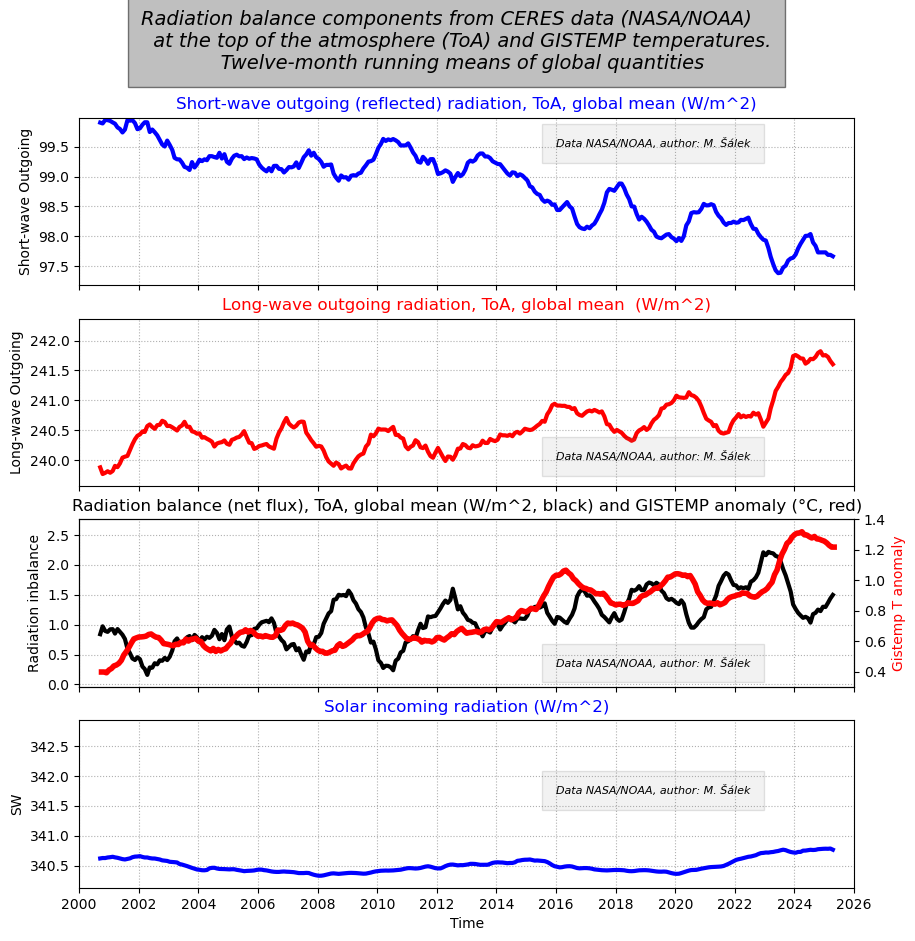

In [35]:

# Plotting:
   
plt.rcParams['figure.figsize'] = [10, 10]
fig, axs = plt.subplots(4, sharex=True)

ylim_range = 2.6
ylim_offset = 0.2

# English version:

axs[0].plot(sw_weighted_mean.time, sw_weighted_mean_smoothed, color="blue", linewidth=3)
axs[0].set_ylim(float(sw_weighted_mean_smoothed.min()) - ylim_offset, 
            float(sw_weighted_mean_smoothed.min() + ylim_range))
axs[0].set_ylabel('Short-wave Outgoing')
axs[0].set_title('Short-wave outgoing (reflected) radiation, ToA, global mean (W/m^2)', color="blue")
axs[0].set_xlim(datetime(2000,1,1), datetime(2026,1,1))
axs[0].xaxis.set_major_locator(mdates.YearLocator(2))

# Optional: format tick labels
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[0].grid(True)

axs[0].grid('on', which='major', axis='y', linestyle=':')
axs[0].grid('on', which='major', axis='x', linestyle=':')
axs[0].text(datetime(2002, 2, 1), 100.8, '''Radiation balance components from CERES data (NASA/NOAA) 
  at the top of the atmosphere (ToA) and GISTEMP temperatures.
             Twelve-month running means of global quantities''',
            style='italic',
            bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=14)
axs[0].text(datetime(2016, 1, 1), 99.5, 'Data NASA/NOAA, author: M. Šálek', style='italic',
        bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 10}, fontsize=8)


axs[1].plot(lw_weighted_mean.time, lw_weighted_mean_smoothed, color="red",linewidth=3)
axs[1].set_ylim(float(lw_weighted_mean_smoothed.min())  - ylim_offset, 
            float(lw_weighted_mean_smoothed.min() + ylim_range))
axs[1].set_ylabel('Long-wave Outgoing')
axs[1].set_title('Long-wave outgoing radiation, ToA, global mean  (W/m^2)', color = 'red')
axs[1].grid('on', which='major', axis='y', linestyle=':')
axs[1].grid('on', which='major', axis='x', linestyle=':')
axs[1].text(datetime(2016, 1, 1), 240, 'Data NASA/NOAA, author: M. Šálek', style='italic',
        bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 10}, fontsize=8)
axs[2].plot(toa_net_weighted_mean.time, toa_net_weighted_mean_smoothed,
            color="black", linewidth=3)

# Adding Gistemp temperature anomaly
axs[2].plot(toa_net_weighted_mean, color="black", linewidth=2)
axs[2].set_ylim(float(toa_net_weighted_mean_smoothed.min())  - ylim_offset, 
            float(toa_net_weighted_mean_smoothed.min() + ylim_range))
axs[2].set_title('Radiation balance (net flux), ToA, global mean (W/m^2, black) and GISTEMP anomaly (°C, red)')
axs[2].grid('on', which='major', axis='y', linestyle=':')
axs[2].grid('on', which='major', axis='x', linestyle=':')
axs[2].text(datetime(2016, 1, 1), 0.3, 'Data NASA/NOAA, author: M. Šálek', style='italic',
        bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 10}, fontsize=8)

ax2b = axs[2].twinx()
# Adding Gistemp temperature anomaly
ax2b.plot(gistemp_months_smoothed.time, gistemp_months_smoothed,
            color="red", linewidth=4)
ax2b.set_ylim(0.3, 1.4) 
axs[2].set_ylabel('Radiation inbalance', color='black', fontsize = 10)
ax2b.set_ylabel('Gistemp T anomaly', color='red', fontsize = 10)

axs[2].grid('on', which='major', axis='y', linestyle=':')
axs[2].grid('on', which='major', axis='x', linestyle=':')
axs[3].plot(solar_incmg_weighted_mean.time, solar_incmg_weighted_mean_smoothed.data, color="blue", linewidth=3)
axs[3].set_xlabel('Time')
axs[3].set_ylim(float(solar_incmg_weighted_mean_smoothed.min())  - ylim_offset, 
            float(solar_incmg_weighted_mean_smoothed.min() + ylim_range))
axs[3].set_ylabel('SW')
axs[3].set_title('Solar incoming radiation (W/m^2)', color="blue")
axs[3].set_xlim(datetime(2000,1,1), datetime(2026,1,1))
axs[3].grid('on', which='major', axis='y', linestyle=':')
axs[3].grid('on', which='major', axis='x', linestyle=':')
axs[3].text(datetime(2016, 1, 1), 341.7, 'Data NASA/NOAA, author: M. Šálek', style='italic',
        bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 10}, fontsize=8)

fig.savefig("CERES_radiation_fluxes_globe_ENG.png")

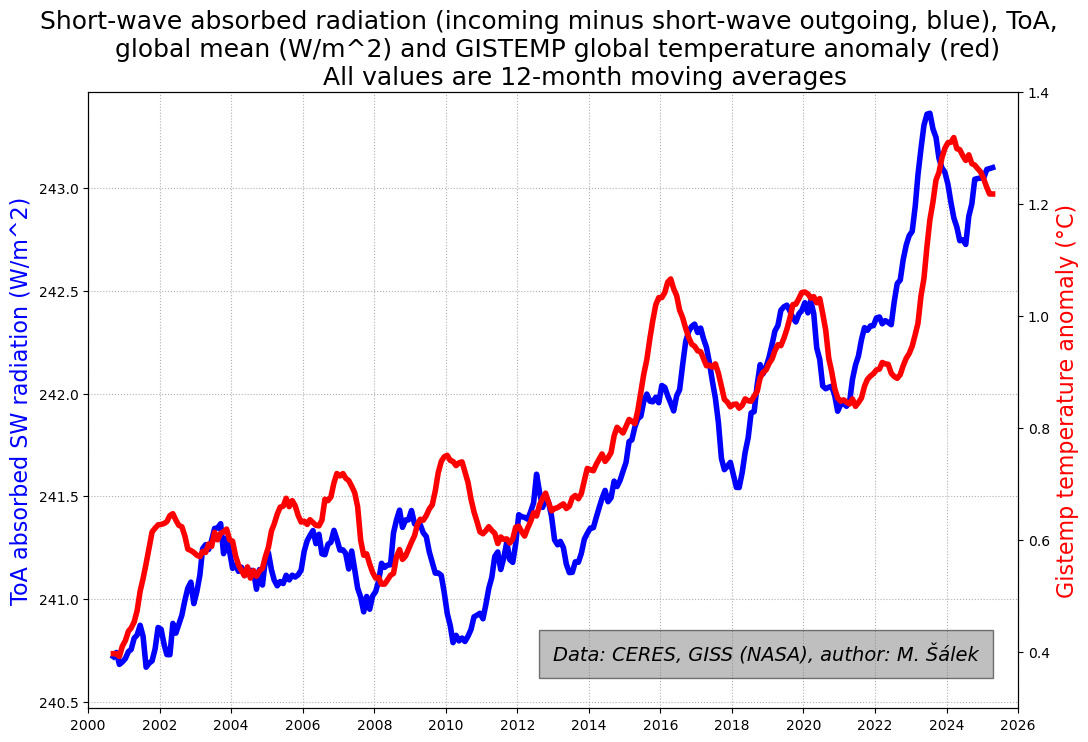

In [36]:
#################################################
# Absorbed radiation and GISTEM temperature
#################################################

ylim_range = 2.8
ylim_offset = 0.2
# Calculation of the absorbed energy (incoming solar irradiance minus outgoing short-wave radiatio)
absorbed_weighted_mean_smoothed = solar_incmg_weighted_mean_smoothed - sw_weighted_mean_smoothed

# print (absorbed_weighted_mean_smoothed)
# print (gistemp_months_smoothed)

# print (type(absorbed_weighted_mean_smoothed))
# print (type(gistemp_months_smoothed))

fig, ax = plt.subplots(1, sharex=True)
#ax.set_aspect(1.5)
ax.plot(absorbed_weighted_mean_smoothed.time, absorbed_weighted_mean_smoothed, color="blue", linewidth=4)
ax.set_ylim(float(absorbed_weighted_mean_smoothed.min()) - ylim_offset, 
            float(absorbed_weighted_mean_smoothed.min() + ylim_range))
ax.set_title('''Short-wave absorbed radiation (incoming minus short-wave outgoing, blue), ToA, 
 global mean (W/m^2) and GISTEMP global temperature anomaly (red)
        All values are 12-month moving averages''', 
             color="black", fontsize = 18)
ax.set_xlim(datetime(2000,1,1), datetime(2026,1,1))
ax.set_xlim(datetime(2000,1,1), datetime(2026,1,1))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

# Optional: format tick labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True)

ax.grid('on', which='major', axis='y', linestyle=':')

ax.grid('on', which='major', axis='x', linestyle=':')
ax.text(datetime(2013, 1, 1), 240.7, '''Data: CERES, GISS (NASA), author: M. Šálek''',
            style='italic',
            bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=14)

ax2 = ax.twinx()
# Adding Gistemp temperature anomaly
ax2.plot(toa_net_weighted_mean.time, gistemp_months_smoothed,
            color="red", linewidth=4)
ax2.set_ylim(0.3, 1.4) 
ax.set_ylabel('ToA absorbed SW radiation (W/m^2)', color='blue', fontsize = 16)
ax2.set_ylabel('Gistemp temperature anomaly (°C)', color='red', fontsize = 16)

ax.grid('on', which='major', axis='y', linestyle=':')
ax.grid('on', which='major', axis='x', linestyle=':')
# ax[0].text(datetime(2016, 1, 1), 0.3, 'Data NASA/NOAA, author: M. Šálek', style='italic',
#         bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 10}, fontsize=8)
fig.set_size_inches(12, 8)
fig.savefig("CERES_abs_sw_radiation_fluxes_globe_and_gistemp.png",)

In [37]:
np.arange(2002, 2026, 2)

array([2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022,
       2024])